<a href="https://colab.research.google.com/github/Yongshilin/Forage-BCG-DA/blob/main/Task_4_modeling(revised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### This notebook was created by Yongshi Lin.

# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling
4. Feature Importances

---

## 1. Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [4]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [40]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV # do hyperparameter tuning for Random Forest using GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import randint

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [41]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)   #10,954 samples and 61 features
print(y_train.shape)   #10,954 labels
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm.

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [43]:
## the example use n_estimators = 1000. Here I am using RandomizedSearchCV to find the best parameters for the Random Forest.

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 200),          # Narrow range for quicker search
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3)
}


rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=3,  # 3-fold cross-validation
                                   n_jobs=-1, # use all available cores
                                   verbose=2,
                                   random_state=42)

# Using a subset to test for the best parameters to speed up the computation process (50% of the data)
X_train_subset = X_train.sample(frac=0.5, random_state=42)
y_train_subset = y_train[X_train_subset.index]

random_search.fit(X_train_subset, y_train_subset)

# Print the best parameters found by RandomizedSearchCV
best_params = random_search.best_params_
best_params

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 154}

In [44]:
# Add model training
model = RandomForestClassifier(**best_params) # Add parameters to the model
model.fit(X_train, y_train) # Complete this method call

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=154)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples

The reason why we are using these three metrics is because a simple accuracy is not always a good measure to use. To give an example, let's say you're predicting heart failures with patients in a hospital and there were 100 patients out of 1000 that did have a heart failure.

If you predicted 80 out of 100 (80%) of the patients that did have a heart failure correctly, you might think that you've done well! However, this also means that you predicted 20 wrong and what may the implications of predicting these remaining 20 patients wrong? Maybe they miss out on getting vital treatment to save their lives.

As well as this, what about the impact of predicting negative cases as positive (people not having heart failure being predicted that they did), maybe a high number of false positives means that resources get used up on thee wrong people and a lot of time is wasted when they could have been helping the real heart failure sufferers.

This is just an example, but it illustrates why other performance metrics are necessary such Precision and Recall, which are good measures to use in a classification scenario.

In [52]:
# Generate predictions
y_pred = model.predict(X_test)  #predict on the test dataset

In [46]:
# Calculate performance metrics
cl = classification_report(y_test, y_pred)
print(f"Classification Report:\n {cl}")

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.93      0.04      0.07       366

    accuracy                           0.90      3652
   macro avg       0.92      0.52      0.51      3652
weighted avg       0.91      0.90      0.86      3652



#### Classfication Report Interpretation:

- Class 0:

Precision: 0.90
Out of all the instances predicted as class 0, 90% were correctly classified.

Recall: 1.00
Out of all the actual instances of class 0, 100% were correctly identified by the classifier.

F1-Score: 0.95
The F1-score is the harmonic mean of precision and recall, giving a balanced measure of the classifier's accuracy for class 0.

Support: 3286
The number of actual occurrences of class 0 in the dataset.

- Class 1:

Precision: 0.93
Out of all the instances predicted as class 1, 93% were correctly classified.

Recall: 0.04
Out of all the actual instances of class 1, only 4% were correctly identified by the classifier. This is very low and indicates that the classifier is not
effectively identifying instances of class 1.

F1-Score: 0.07
The F1-score is very low due to the poor recall, indicating that the model struggles with class 1.

Support: 366
The number of actual occurrences of class 1 in the dataset.


- Accuracy: 0.90.
Meaning that 90% of all instances were correctly classified.

- Macro Avg:

Precision: 0.92
The unweighted average precision across all classes.

Recall: 0.52
The unweighted average recall across all classes. The low recall for class 1 significantly lowers this value.

F1-Score: 0.51
The unweighted average F1-score across all classes, reflecting the poor performance on class 1.

- Weighted Avg:

Precision: 0.91
The average precision across all classes, weighted by the number of true instances (support) of each class.

Recall: 0.90
The average recall across all classes, weighted by support.

F1-Score: 0.86
The average F1-score across all classes, weighted by support.

In [47]:
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {cm}")

Confusion Matrix:
 [[3285    1]
 [ 352   14]]


In [53]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")
print(f"False positives: {fp}")

True negatives: 3285
False negatives: 352
True positives: 14
False positives: 1


#### Confusion Matrix:
- True Negatives(TN): we have 3285 out of 3286. This means that out of all the negative cases (churn = 0), we predicted 3285 as negative.
- False Negatives(FN): this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is quite high at 352, we want to get the false negatives to as close to 0 as we can, so this would need to be addressed when improving the model.
- True Positives(TP): We are only able to correctly identify 14 of those 366, which is very poor.
- False Positives(FP): this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 1 cases, which is great!

In [49]:
y_test.shape

(3652,)

In [50]:
y_test.value_counts()

,count
churn,
0,3286
1,366


In [62]:
# Calculate the proportion of instances for each churn value
churn_proportions = y_test.value_counts(normalize=True)

print(f"Proportion of instances with churn = 0: {churn_proportions[0]:.2%}")
print(f"Proportion of instances with churn = 1: {churn_proportions[1]:.2%}")

## or
# for churn_value, proportion in churn_proportions.items():
    # print(f"Proportion of instances with churn = {churn_value}: {proportion:.2%}")

Proportion of instances with churn = 0: 89.98%
Proportion of instances with churn = 1: 10.02%


In [51]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision: {metrics.precision_score(y_test, y_pred)}")
print(f"Recall: {metrics.recall_score(y_test, y_pred)}")

Accuracy: 0.9033406352683461
Precision: 0.9333333333333333
Recall: 0.03825136612021858


#### Overall Metrics:
- Accuracy: The overall accuracy of the model is 90%, meaning that 90% of all instances were correctly classified.
*Accuracy Score =Correct Predictors/Total Predictors = (3285+14)/3652 = 90.33%

- Precision Score: 93.33% is quite high, which is great.

- Recall Score : 4% is very low, and is from the class 1. It means the classifier has a very poor ability to identify positive samples. We need to improve the model.

Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.

#### Interpretation
##### Overall:
- Imbalanced prediction: The classifier performs very well on class 0(Churn = 0), as indicated by the high recall(1.00) and F1-score(0.95) for class 0; but struggles significantly with class 1(Churn = 1), as indicated by the low recall (0.04) and F1-score (0.07) for class 1.
- Imbanlance in the dataset: There are 90% instances(3286/3652) of class 0 but only 10%(366/3652) instances of class 1 in the test dataset, indicating that the dataset is imbalanced. This could be why the model is biased towards class 0.
- Poor performance in minority class: Despite the high overall accuracy (90%), the model's performance on the minority class (class 1) is poor. This discrepancy highlights the importance of not relying solely on accuracy as a performance metric in imbalanced datasets.
- Next Steps: To improve the model's performance on class 1, we might consider techniques like oversampling the minority class, using different metrics for model evaluation, or adjusting the class weights in the model.

### Feature Importance
A simple way of understanding the results of a model is to look at feature importances (which features are most influential in the model's decisions).

With the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model.

In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [77]:
feature_importances = pd.Series(model.feature_importances_, index = X_train.columns)

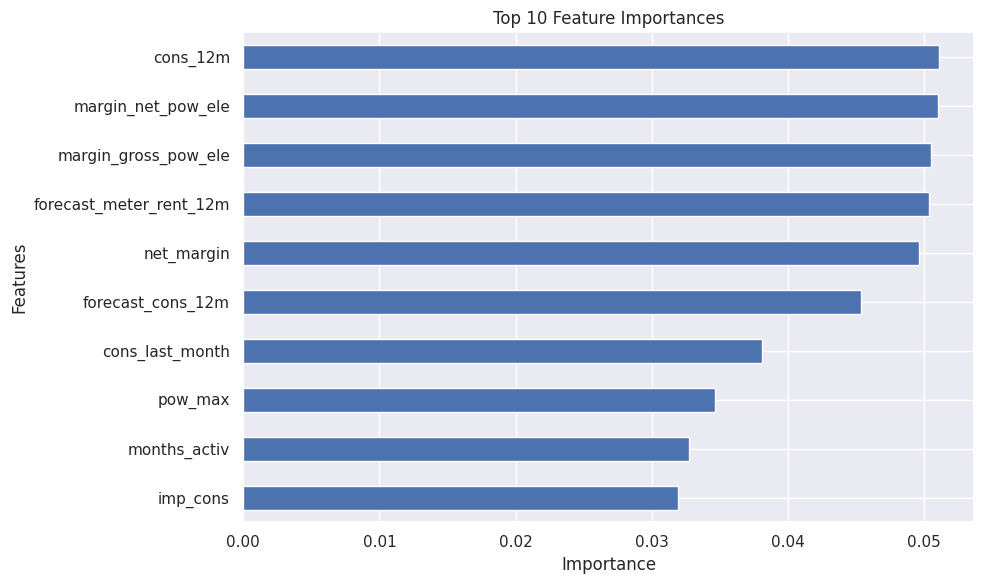

In [89]:
plt.figure(figsize=(10, 6))

top_features = feature_importances.sort_values(ascending = False).head(10)
top_features.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top

plt.tight_layout()
plt.show()

In [75]:
# same result, different method, this is to get all the feature importances
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

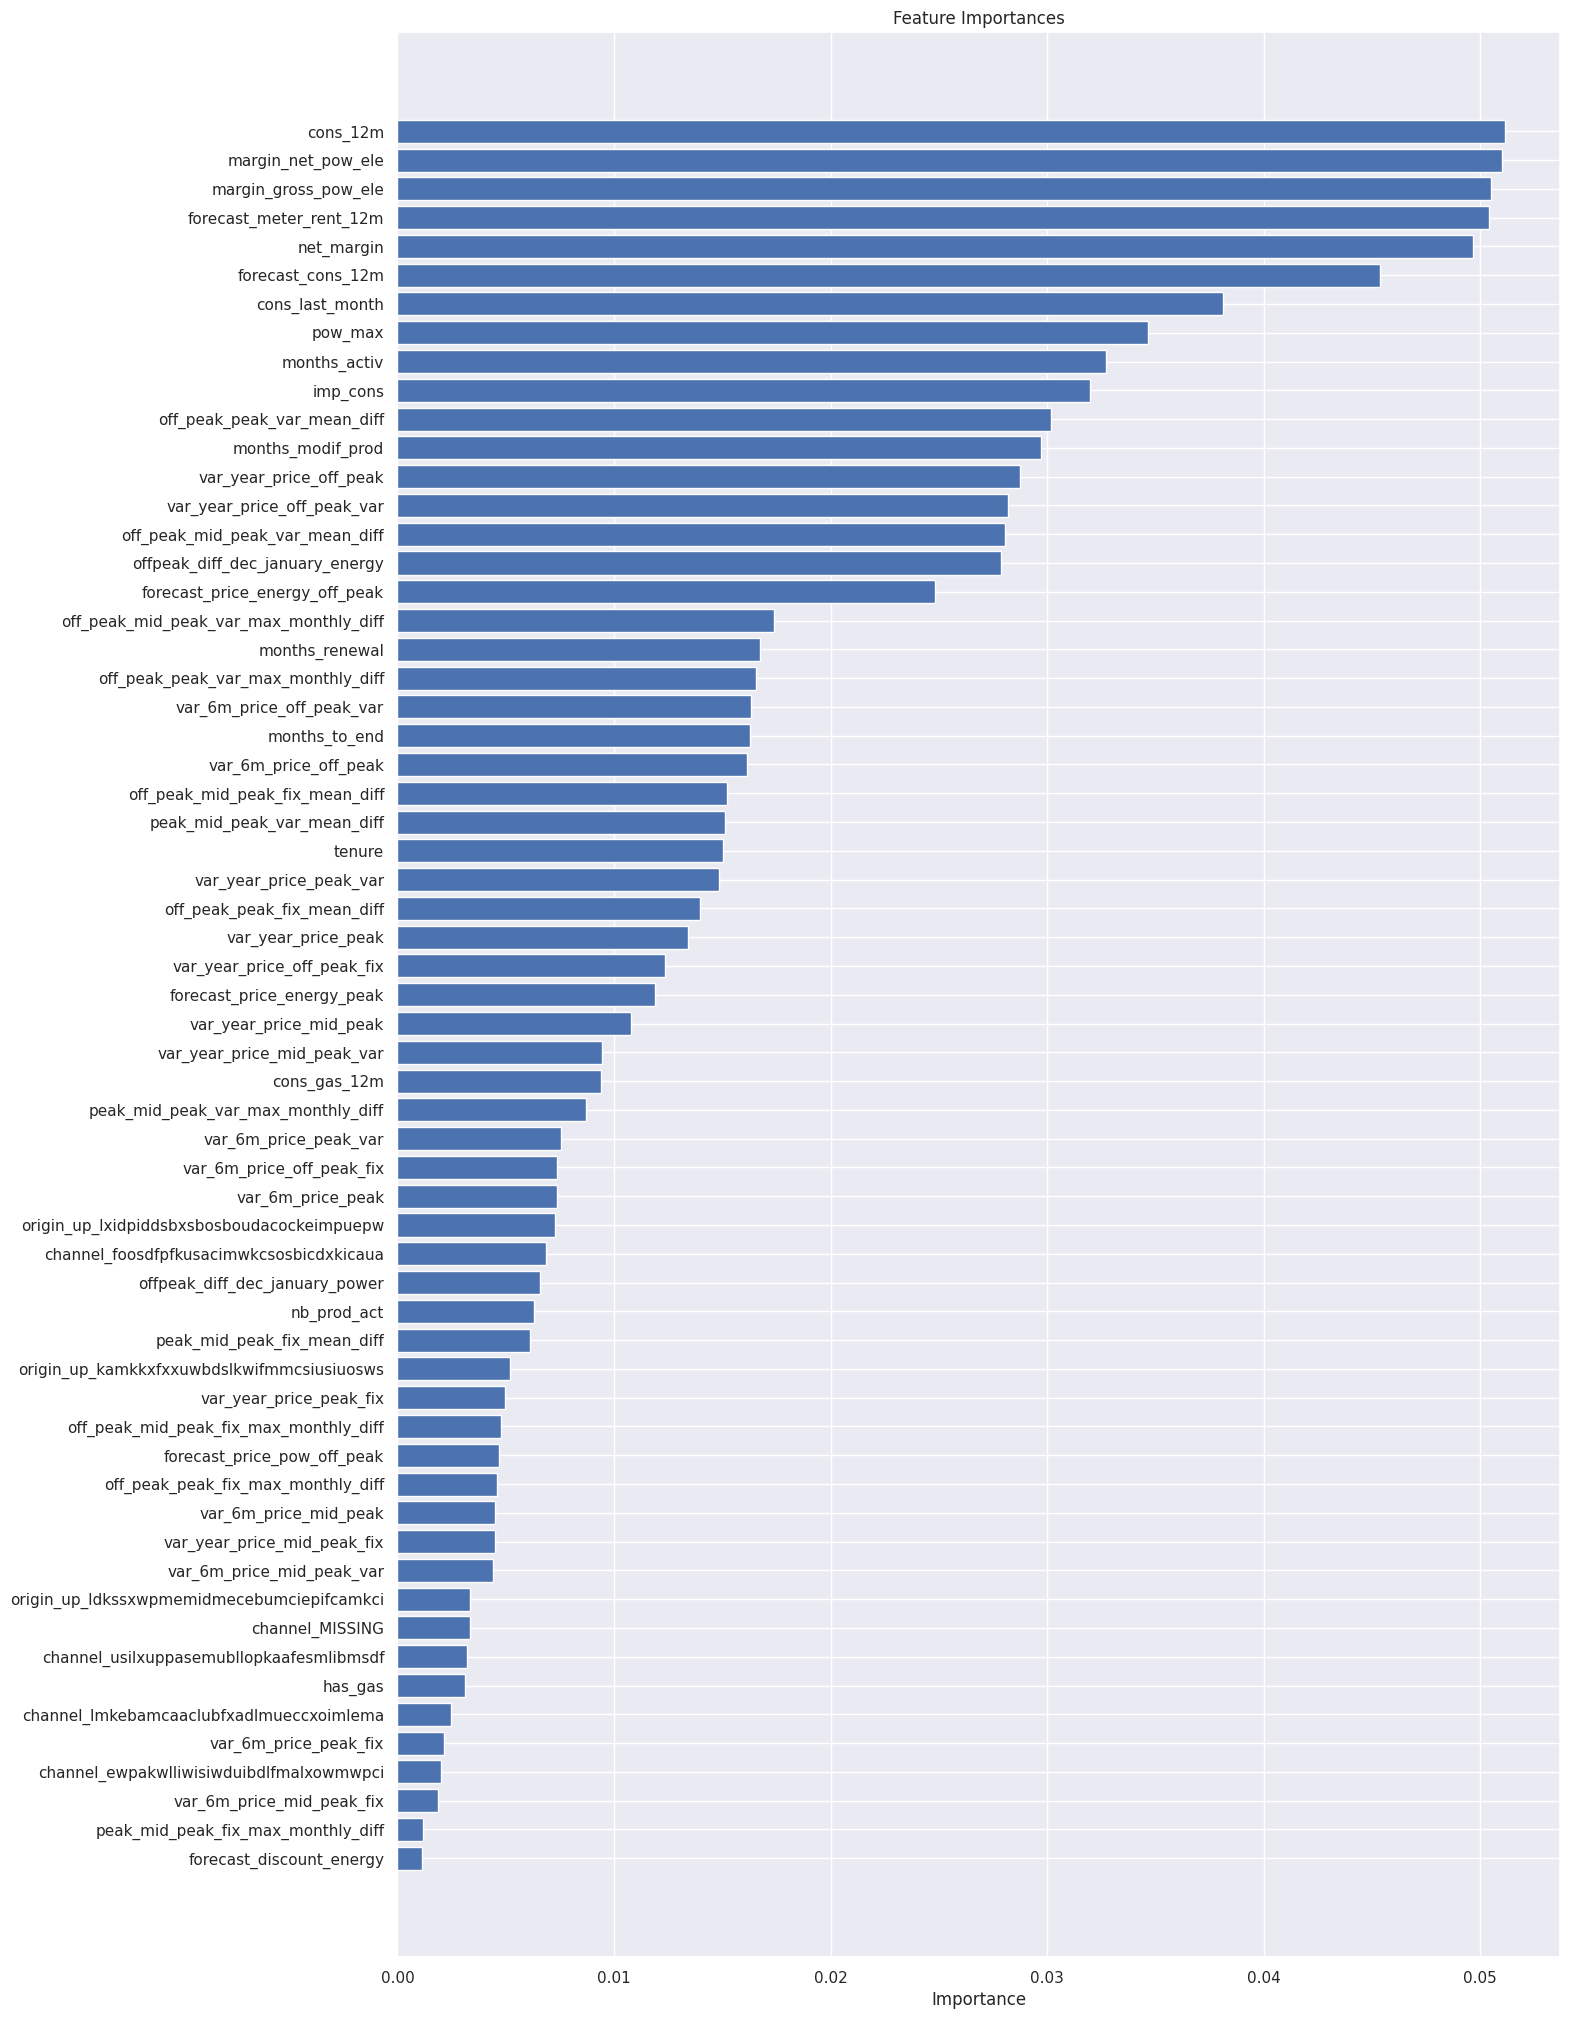

In [76]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

##### From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model;

- Margin on power subscription also is an influential driver;

- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract;

- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it;

- Our price sensitivity features are scattered around but are not the main driver for a customer churning.

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [90]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:,1]

In [91]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [94]:
X_test['churn'] = y_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,4.173390,4.193598,3.165541,3.168368,0.0,2.073828,0.114667,0.099548,40.606701,1,...,0,0,1,0,0,0,0,1,0,0.105985
1,4.075036,0.000000,3.003461,3.305998,30.0,1.255031,0.198096,0.000000,46.305378,0,...,0,0,1,0,0,0,0,1,0,0.192115
2,3.848435,0.000000,0.000000,2.756568,0.0,1.289366,0.141434,0.000000,44.311378,0,...,0,0,1,0,0,0,0,1,0,0.024003
3,4.345433,0.000000,0.000000,3.516690,0.0,1.304921,0.142996,0.000000,44.311378,0,...,0,0,1,0,0,0,0,1,0,0.079586
4,4.185655,0.000000,3.355834,3.208148,0.0,2.123067,0.120372,0.103487,40.606701,0,...,0,0,1,0,0,0,1,0,0,0.049782


In [95]:
X_test.to_csv('out_of_sample_data_with_predictions.csv')